# Neural Network for MNIST dataset of digit recognition

Tutorial: https://www.geeksforgeeks.org/handwritten-digit-recognition-using-neural-network/

In [3]:
from scipy.io import loadmat
import numpy as np
from scipy.optimize import minimize
from tkinter import *
from PIL import ImageGrab
import matplotlib.pyplot as plt

In [4]:
# HYPERPARAMETERS
normalisation_factor = 1/255        # Each pixel = 8-bit integer (0-255)
input_layer_size = 28 * 28          # Number of features (pixels)
hidden_layer_size = 100             # Number of hidden units
num_labels = 10                     # Number of labels (0-9)
maxiter = 100                       # Maximum number of iterations for optimization
lambda_reg = 0.1                    # Regularization parameter (prevents overfitting)
epsilon = 0.15                      # Random initialisation parameter (prevents symmetry)

In [5]:
# Load mat file of data
data = loadmat('../data/mnist-original.mat')
print("Keys: ", data.keys())
print("Dataset shape: ", data['data'].shape)

Keys:  dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])
Dataset shape:  (784, 70000)


In [6]:
# Extract features and transpose
X = data['data'].T

# Normalise the data so that each pixel is in the range [0, 1]
X = X * normalisation_factor

# Extract labels from data and flatten
y = data['label'].flatten()

print("Data, X:\n ", X, "\n", X.shape)
print("\nLabels, y:\n ", y, "\n", y.shape)

Data, X:
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 (70000, 784)

Labels, y:
  [0. 0. 0. ... 9. 9. 9.] 
 (70000,)


In [7]:
# Split data into training set with 60,000 samples and test set with 10,000 samples (capital for matrix, lower case for vector)
X_train = X[:60000, :]
y_train = y[:60000]
print("Training size: ", X_train.shape, y_train.shape)

# (2nd colon specifies all columns)
X_test = X[60000:, :]
y_test = y[60000:]
print("Testing size: ", X_test.shape, y_test.shape)

Training size:  (60000, 784) (60000,)
Testing size:  (10000, 784) (10000,)


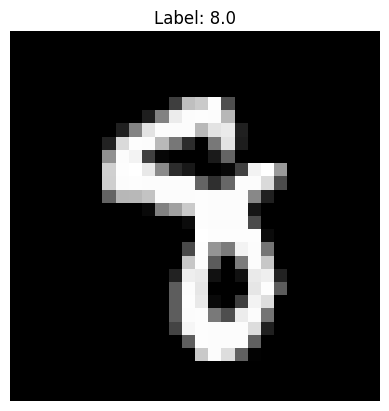

In [8]:
# Display a sample image (random by default)
def show_image(X, y, index=None):
    # Choose a random index if none is provided
    if index is None:
        N = X.shape[0]
        index = np.random.randint(0, N - 1)
    
    # Extract image data and label
    image = X[index].reshape(28, 28)
    label = y[index]
    
    # Display image and label
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    
# Choose a random index from the total number of images
show_image(X, y)

In [9]:
# Function to randomly initialise Thetas (weights) between a range of [-epsilon, epsilon]
def initialise(a, b, epsilon):
    # Scale and shift random values to be within range
    c = (np.random.rand(a, b + 1) * (2 * epsilon)) - epsilon
    
    # Returns matrix of randomly initialised weights, of dimensions a x (b + 1)
    return c

# epsilon chosen arbitrarily (small enough to avoid saturation and large enough to avoid vanishing gradients)
initial_Theta1 = initialise(hidden_layer_size, input_layer_size, epsilon)
initial_Theta2 = initialise(num_labels, hidden_layer_size, epsilon)
print("Theta1:\n ", initial_Theta1, "\n", initial_Theta1.shape)
print("\nTheta2:\n ", initial_Theta2, "\n", initial_Theta2.shape)

Theta1:
  [[-0.04527519  0.08645128  0.14967121 ...  0.07467268  0.06095429
   0.04433275]
 [-0.09904031  0.0290568  -0.14613074 ... -0.10664474 -0.02712011
  -0.02680306]
 [ 0.01665128  0.0030571  -0.05333852 ...  0.05423247 -0.12142121
  -0.08264388]
 ...
 [ 0.137579    0.01700141 -0.03070998 ... -0.08180259 -0.11630904
   0.10520473]
 [ 0.14407801 -0.10849045  0.00265089 ... -0.09612479 -0.14631937
   0.1313735 ]
 [ 0.13763594 -0.13086071  0.00963977 ...  0.13377163  0.14006473
  -0.05710927]] 
 (100, 785)

Theta2:
  [[-0.00038299  0.00455358  0.01991931 ... -0.06763254 -0.13778855
   0.03102605]
 [ 0.01053874 -0.14669422  0.01132565 ...  0.1010875   0.06238535
  -0.02759254]
 [-0.0211659   0.07241686  0.03259435 ... -0.08010295  0.01874264
  -0.09616889]
 ...
 [-0.13047035  0.00480696  0.10801566 ... -0.14478112  0.10217228
  -0.01086469]
 [-0.14162883 -0.09464915 -0.09268031 ... -0.12021677 -0.0103491
   0.12441632]
 [ 0.06603339  0.06658141 -0.12491322 ...  0.14075797 -0.04980631

In [35]:
# Unroll (combine) the weight matrices into a single column vector (easier for optimisation algorithm)
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()))
print("Initial parameters: ", initial_nn_params.shape)

Initial parameters:  (79510,)


#### Why 79,510?
`Theta1`
-   hidden_layer_size * (input_layer_size + 1)
-   100 * (784 + 1)
-   78,500

`Theta2`
-   num_labels * (hidden_layer_size + 1)
-   10 * (100 + 1)
-   1,010

`TOTAL`
-   79,510

In [34]:
# Activation function for forward propagation
def activation_function(z, function_name="sigmoid", alpha=0.01):
    # Range: [0, 1] - used for binary classification
    if function_name == "sigmoid":
        return 1 / (1 + np.exp(-z))
    
    # Range: [-1, 1] - zero-centred, used in hidden layers
    elif function_name == "tanh":
        return np.tanh(z)
    
    # Range: [0, inf) - outputs 0 for z < 0 and z for z >= 0
    elif function_name == "relu":
        return np.maximum(0, z)
    
    # Range: (-inf, inf) - outputs z for z >= 0 and alpha * z for z < 0
    elif function_name == "leaky_relu":
        return np.where(z > 0, z, alpha * z)
    
    # Range: [0, 1] - used in output layers for multi-class classification
    elif function_name == "softmax":
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    # Range: (-inf, inf) - linear activation
    elif function_name == "linear":
        return z
    
    # Range: [0, 6] - smooth approximation of ReLU
    elif function_name == "softplus":
        return np.log1p(np.exp(z))
    
    # Range: [-1, 1] - scaled and shifted sigmoid
    elif function_name == "hard_sigmoid":
        return np.maximum(0, np.minimum(1, (z + 1) / 2))
    
    # Range: (-1, 1) - similar to tanh but with a sharper bend
    elif function_name == "hard_tanh":
        return np.maximum(-1, np.minimum(1, z))
    
    # Range: [0, inf) - similar to ReLU but smoother near 0
    elif function_name == "elu":
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))
    
    # Range: (-inf, inf) - scaled ReLU
    elif function_name == "selu":
        lambda_ = 1.0507
        alpha = 1.67326
        return lambda_ * np.where(z > 0, z, alpha * (np.exp(z) - 1))
    
    else:
        raise ValueError(f"Unsupported activation function: {function_name}")

# Test the function
z = np.array([[-1, 0, 1], [2, -2, 3]])

print("Examples of how activation functions affect the matrix: \n", z)
print("\nSigmoid:\n", activation_function(z, "sigmoid"))
print("\nTanh:\n", activation_function(z, "tanh"))
print("\nReLU:\n", activation_function(z, "relu"))
print("\nLeaky ReLU:\n", activation_function(z, "leaky_relu"))
print("\nSoftmax:\n", activation_function(z, "softmax"))
print("\nLinear:\n", activation_function(z, "linear"))
print("\nSoftplus:\n", activation_function(z, "softplus"))
print("\nHard Sigmoid:\n", activation_function(z, "hard_sigmoid"))
print("\nHard Tanh:\n", activation_function(z, "hard_tanh"))
print("\nELU:\n", activation_function(z, "elu"))
print("\nSELU:\n", activation_function(z, "selu"))

Examples of how activation functions affect the matrix: 
 [[-1  0  1]
 [ 2 -2  3]]

Sigmoid:
 [[0.26894142 0.5        0.73105858]
 [0.88079708 0.11920292 0.95257413]]

Tanh:
 [[-0.76159416  0.          0.76159416]
 [ 0.96402758 -0.96402758  0.99505475]]

ReLU:
 [[0 0 1]
 [2 0 3]]

Leaky ReLU:
 [[-0.01  0.    1.  ]
 [ 2.   -0.02  3.  ]]

Softmax:
 [[0.09003057 0.24472847 0.66524096]
 [0.26762315 0.00490169 0.72747516]]

Linear:
 [[-1  0  1]
 [ 2 -2  3]]

Softplus:
 [[0.31326169 0.69314718 1.31326169]
 [2.12692801 0.12692801 3.04858735]]

Hard Sigmoid:
 [[0.  0.5 1. ]
 [1.  0.  1. ]]

Hard Tanh:
 [[-1  0  1]
 [ 1 -1  1]]

ELU:
 [[-0.00632121  0.          1.        ]
 [ 2.         -0.00864665  3.        ]]

SELU:
 [[-1.11132754  0.          1.0507    ]
 [ 2.1014     -1.52016209  3.1521    ]]


In [42]:
# Perform forward propagation on the training data maxtrix and weight matrices
def forward_propagation(X, Theta1, Theta2):
    m = X.shape[0]
    ones = np.ones((m, 1))                  # Ones matrix for bias unit (60,000 x 1)
    X = np.append(ones, X, axis=1)          # Add bias unit to input layer (60,000 x 785)
    a1 = X                                  # Input layer
    z2 = np.dot(a1, Theta1.T)               # Compute z2 for hidden layer (60,000 x 100)
    a2 = activation_function(z2, 'sigmoid')
    a2 = np.append(ones, a2, axis=1)        # Add bias unit to hidden layer (60,000 x 101)
    z3 = np.dot(a2, Theta2.T)               # Compute z3 for output layer (60,000 x 10)
    a3 = activation_function(z3, 'sigmoid')
    
    return a1, z2, a2, z3, a3

# Calculate the cost function
def cost_function(a3, y, Theta1, Theta2, lamb):
    m = y.shape[0]
    num_labels = a3.shape[1]
    
    # Convert y labels into binary vectors
    y_vect = np.zeros((m, num_labels))          # Zeros 60,000 x 10
    for i in range(m):                          # For each row in y
        y_vect[i, int(y[i])] = 1                # Set the value at the index of the label to 1 (e.g. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # Calculate the cost (loss + regularization)
    J = (
        (1 / m) * (np.sum(-y_vect * np.log(a3) - (1 - y_vect) * np.log(1 - a3)))
        + 
        (lamb / (2 * m)) * (np.sum(np.sum(Theta1[:, 1:] ** 2)) + np.sum(np.sum(Theta2[:, 1:] ** 2)))
    )
    
    return J

# Perform back propagation on the data matrix and weight matrices
def back_propagation(a1, z2, a2, a3, y, Theta1, Theta2):
    m = y.shape[0]
    num_labels = a3.shape[1]
    
    # Convert y labels into binary vectors
    y_vect = np.zeros((m, num_labels))          # Zeros 60,000 x 10
    for i in range(m):                          # For each row in y
        y_vect[i, int(y[i])] = 1                # Set the value at the index of the label to 1 (e.g. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # Compute deltas
    Delta3 = a3 - y_vect
    Delta2 = np.dot(Delta3, Theta2) * a2 * (1 - a2)
    Delta2 = Delta2[:, 1:]  # Remove bias term from Delta2
    
    return Delta3, Delta2

# Compute the gradients of the cost function
def compute_gradients(Delta2, Delta3, a1, a2, Theta1, Theta2, lamb):
    m = a1.shape[0]
    
    # Set the first column of Theta1 and Theta2 to zero (bias terms are not regularized)
    Theta1[:, 0] = 0
    Theta2[:, 0] = 0
    
    # Compute the gradients
    Theta1_grad = (1 / m) * np.dot(Delta2.T, a1) + (lamb / m) * Theta1
    Theta2_grad = (1 / m) * np.dot(Delta3.T, a2) + (lamb / m) * Theta2
    
    # Flatten gradients to return a single vector
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    
    return grad


# Create the neural network model
def neural_network(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    # Unroll the parameters
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1))
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (num_labels, hidden_layer_size + 1))
    
    # Forward propagation
    a1, z2, a2, z3, a3 = forward_propagation(X, Theta1, Theta2)
    
    # Cost function
    J = cost_function(a3, y, Theta1, Theta2, lamb)
    
    # Back propagation
    Delta3, Delta2 = back_propagation(a1, z2, a2, a3, y, Theta1, Theta2)
    
    # Compute gradients
    grad = compute_gradients(Delta2, Delta3, a1, a2, Theta1, Theta2, lamb)
    
    return J, grad

`scipy.optimize.minimize`
Generic optimisation function to find the minimum of a scalar function
-   Objective Function: cost function of NN
-   Initial Guess: initial estimate of params (weights) to optimise
-   Method: optimisation algorithm to be used
-   Jac: Jacobian (gradient) of objective function
-   Options: e.g. number of iterations

In [36]:
# Package all arguments into a tuple for optimisation function
myargs = (input_layer_size, hidden_layer_size, num_labels, X_train, y_train, lambda_reg)

# Minimise the cost function using the L-BFGS-B optimisation algorithm
results = minimize(neural_network, x0=initial_nn_params, args=myargs, options={'disp': True, 'maxiter': maxiter}, method='L-BFGS-B', jac=True)
print(results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        79510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67378D+00    |proj g|=  5.15862D-01


 This problem is unconstrained.



At iterate    1    f=  3.35710D+00    |proj g|=  5.89480D-02

At iterate    2    f=  3.25141D+00    |proj g|=  3.61778D-02

At iterate    3    f=  3.20114D+00    |proj g|=  2.49376D-02

At iterate    4    f=  3.15153D+00    |proj g|=  3.00432D-02


KeyboardInterrupt: 

`Objective / Cost function`
| Variable | Definition                                                                     |
| -------- | -------                                                                        |
| N        | total number of variables (parameters, weights)                                |
| M        | number of corrections (updates) stored in memory by the algorithm              |
| X0       | none of the variables are at their bounds                                      |
| f        | current value of cost function                                                 |
| proj g   | norm of projected gradient (how close optimisation is to a stationary point)   |
| success  | whether optimisation converged or not (did not)                                |
| fun      | value of cost function @ final params                                          |
| x        | final values of params (weights)                                               |
| nit      | number of iterations performed                                                 |
| jac      | gradient of cost function @ final params                                       |
| nfev     | # times cost function was evaluated                                            |
| njev     | # times gradient was evaluated                                                 |
| hess_inv | inverse of the approx Hessian matrix @ final point (helps understand curvature)|

In [14]:
# Extract the optimised weights (trained Theta)
nn_params = results["x"]
print("Optimised weights: \n", nn_params, "\n", nn_params.shape)

Optimised weights: 
 [-0.58609539  0.13218445  0.11142981 ... -2.93568529  0.56368882
  0.02294904] 
 (79510,)


In [15]:
# Split weights back into Theta1 (100 x 785) and Theta2 (10 x 101)
Theta1 = np.reshape(nn_params[:(hidden_layer_size * (input_layer_size + 1))], (hidden_layer_size, (input_layer_size + 1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))
print(Theta1.shape, Theta2.shape)

(100, 785) (10, 101)


In [16]:
# Performs forward propagation to predict the label (digit) of an input image
def predict(Theta1, Theta2, X):
    m = X.shape[0] 
    ones = np.ones((m, 1))                      # Ones matrix
    X = np.append(ones, X, axis=1)              # Add bias unit to input (first) layer 
    z2 = np.dot(X, Theta1.transpose()) 
    a2 = 1 / (1 + np.exp(-z2))                  # Activation for hidden (second) layer
    ones = np.ones((m, 1)) 
    a2 = np.append(ones, a2, axis=1)            # Adding bias unit to hidden layer 
    z3 = np.dot(a2, Theta2.transpose()) 
    a3 = 1 / (1 + np.exp(-z3))                  # Activation for output (third) layer 
    p = (np.argmax(a3, axis=1))                 # Predicting the class on the basis of max value of hypothesis 
    return p 


# Check test set accuracy of model
pred = predict(Theta1, Theta2, X_test)
print("Test set accuracy: ", np.mean(pred == y_test) * 100)

# Check train set accuracy of model
pred = predict(Theta1, Theta2, X_train)
print("Train set accuracy: ", np.mean(pred == y_train) * 100)

Test set accuracy:  97.28
Train set accuracy:  99.50333333333333


In [17]:
# Evaluate precision of model 
true_positive = 0

# Iterate through predictions and compare with actual labels
for i in range(len(pred)):
    if pred[i] == y_train[i]:
        true_positive += 1
        
# Calculate precision
false_positive = len(y_train) - true_positive 
print('Precision =', true_positive/(true_positive + false_positive))

Precision = 0.9950333333333333


In [18]:
# Save Thetas in .txt files: (100 x 785) and (10 x 101)
np.savetxt('Theta1.txt', Theta1, delimiter=' ') 
np.savetxt('Theta2.txt', Theta2, delimiter=' ')

In [20]:
# Pop up widget to draw digit and output model prediction
window = Tk() 
window.title("Handwritten digit recognition") 
l1 = Label() 


def MyProject():
	global l1 

	widget = cv 
	# Setting co-ordinates of canvas
	x = window.winfo_rootx() + widget.winfo_x() 
	y = window.winfo_rooty() + widget.winfo_y() 
	x1 = x + widget.winfo_width() 
	y1 = y + widget.winfo_height() 

	# Image is captured from canvas and is resized to (28 X 28) px 
	img = ImageGrab.grab().crop((x, y, x1, y1)).resize((28, 28)) 

	# Converting rgb to grayscale image 
	img = img.convert('L') 

	# Extracting pixel matrix of image and converting it to a vector of (1, 784) 
	x = np.asarray(img) 
	vec = np.zeros((1, 784)) 
	k = 0
	for i in range(28): 
		for j in range(28): 
			vec[0][k] = x[i][j] 
			k += 1

	# Loading Thetas 
	Theta1 = np.loadtxt('Theta1.txt') 
	Theta2 = np.loadtxt('Theta2.txt')

	# Calling function for prediction 
	pred = predict(Theta1, Theta2, vec / 255)

	# Displaying the result 
	l1 = Label(window, text="Digit = " + str(pred[0]), font=('Algerian', 20)) 
	l1.place(x=230, y=420) 


lastx, lasty = None, None


# Clears the canvas 
def clear_widget(): 
	global cv, l1 
	cv.delete("all") 
	l1.destroy() 


# Activate canvas
def event_activation(event): 
	global lastx, lasty 
	cv.bind('<B1-Motion>', draw_lines) 
	lastx, lasty = event.x, event.y 


# To draw on canvas 
def draw_lines(event): 
	global lastx, lasty 
	x, y = event.x, event.y 
	cv.create_line((lastx, lasty, x, y), width=30, fill='white', capstyle=ROUND, smooth=TRUE, splinesteps=12) 
	lastx, lasty = x, y 


# Label 
L1 = Label(window, text="Handwritten Digit Recoginition", font=('Algerian', 25), fg="blue") 
L1.place(x=35, y=10) 

# Button to clear canvas 
b1 = Button(window, text="1. Clear Canvas", font=('Algerian', 15), bg="orange", fg="black", command=clear_widget) 
b1.place(x=120, y=370) 

# Button to predict digit drawn on canvas 
b2 = Button(window, text="2. Prediction", font=('Algerian', 15), bg="white", fg="red", command=MyProject) 
b2.place(x=320, y=370) 

# Setting properties of canvas 
cv = Canvas(window, width=350, height=290, bg='black') 
cv.place(x=120, y=70) 

cv.bind('<Button-1>', event_activation) 
window.geometry("600x500") 
window.mainloop() 
